<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/geographic_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
!pip install -q geocoder
!pip install -q --upgrade xlrd
!pip install -q japanize-matplotlib

     |████████████████████████████████| 4.1 MB 7.3 MB/s 


In [42]:
import requests
import json
import pandas as pd
from urllib.parse import urlparse
import geocoder
import math
import io
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [3]:
def get_data_csv_url(url, encoding='utf-8', excel=False):
    res = requests.get(url)
    if res.status_code == 200:
        if not excel:
            return pd.read_csv(io.BytesIO(res.content), encoding=encoding)
        else:
            return pd.read_excel(io.BytesIO(res.content))
    else:
        raise Exception(f'status_code: {res.status_code} ({url})')

In [4]:
def number_to_kanji(str):
    return str.translate(str.maketrans({'１':'一', '２':'二', '３':'三', '４':'四', '５':'五', '６':'六', '７':'七', '８':'八', '９':'九'}))

In [5]:
def add_pref_district(df_data, district, is_master=False):
    df_data['都道府県'] = '東京都'
    df_data['市区町村'] = district
    if is_master:
        df_data['町丁目'] = df_data['町丁目'].apply(number_to_kanji)
        df_data['町名'] = df_data['町丁目'].str.replace('[一二三四五六七八九十]丁目', '', regex=True)

### 港区マスター

In [6]:
minato_master_url = 'https://opendata.city.minato.tokyo.jp/dataset/213a32cd-85de-4c30-aaf9-7164c5bf06c9/resource/bc0beb3f-ca1d-45a3-87ea-8e190bb34d27/download/chomokubetsu_2022.csv'
df_minato_master = get_data_csv_url(minato_master_url)
df_minato_master = df_minato_master.dropna(subset=['人口合計［人］'])
add_pref_district(df_minato_master, '港区', True)
df_minato_master = df_minato_master.sort_values('年月日［西暦］', ascending=False).drop_duplicates(subset=['町丁目'])
df_minato_master = df_minato_master.drop(columns=['年月日［西暦］'])
df_minato_master = df_minato_master.sort_values('町丁目').reset_index(drop=True)
df_minato_master.rename(columns={'人口男［人］': '人口男', '人口女［人］': '人口女', '人口合計［人］': '人口合計'}, inplace=True)
df_minato_master.drop(columns=['地区'], inplace=True)
print(df_minato_master.shape)

(117, 8)


In [7]:
df_minato_master.head()

,町丁目,世帯数,人口男,人口女,人口合計,都道府県,市区町村,町名
0,三田一丁目,2269.0,1818.0,2177.0,3995.0,東京都,港区,三田
1,三田三丁目,1083.0,803.0,866.0,1669.0,東京都,港区,三田
2,三田二丁目,2406.0,2033.0,2481.0,4514.0,東京都,港区,三田
3,三田五丁目,3606.0,2922.0,3622.0,6544.0,東京都,港区,三田
4,三田四丁目,2020.0,1612.0,1966.0,3578.0,東京都,港区,三田


### 墨田区マスター

In [8]:
sumida_master_url = 'https://www.city.sumida.lg.jp/kuseijoho/sumida_info/opendata/opendata_ichiran/population_data/setai_all_data.files/setai_all_2208.csv'
df_sumida_master = get_data_csv_url(sumida_master_url, 'shift-jis')
add_pref_district(df_sumida_master, '墨田区', True)
df_sumida_master = df_sumida_master.sort_values('町丁目').reset_index(drop=True)
df_sumida_master.rename(columns={'世帯数[世帯]': '世帯数', '男[人]': '人口男', '女[人]': '人口女', '総数[人]': '人口合計'}, inplace=True)
print(df_sumida_master.shape)

(104, 8)


In [9]:
df_sumida_master.head()

,町丁目,世帯数,人口男,人口女,人口合計,都道府県,市区町村,町名
0,両国一丁目,1206,888,884,1772,東京都,墨田区,両国
1,両国三丁目,1396,1016,1021,2037,東京都,墨田区,両国
2,両国二丁目,1422,1065,1112,2177,東京都,墨田区,両国
3,両国四丁目,1405,1093,1087,2180,東京都,墨田区,両国
4,亀沢一丁目,1290,1031,1099,2130,東京都,墨田区,亀沢


### 練馬区マスター

In [10]:
nerima_master_url = 'https://www.city.nerima.tokyo.jp/kusei/tokei/opendata/opendatasite/tokei_kusei/chouchoubetu.files/202207chouchoubetu.csv'
df_nerima_master = get_data_csv_url(nerima_master_url, 'shift-jis')
add_pref_district(df_nerima_master, '練馬区', True)
df_nerima_master = df_nerima_master[df_nerima_master['町丁目'].str.contains('丁目')]
df_nerima_master.rename(columns={'世帯数[世帯]': '世帯数', '人口（男）[人]': '人口男', '人口（女）[人]': '人口女', '計[人]': '人口合計'}, inplace=True)
print(df_nerima_master.shape)

(198, 8)


In [11]:
df_nerima_master.head()

,町丁目,世帯数,人口男,人口女,人口合計,都道府県,市区町村,町名
2,旭丘一丁目,3350,2478,2392,4870,東京都,練馬区,旭丘
3,旭丘二丁目,1552,1179,1268,2447,東京都,練馬区,旭丘
5,小竹町一丁目,3137,2491,2703,5194,東京都,練馬区,小竹町
6,小竹町二丁目,2596,2034,2315,4349,東京都,練馬区,小竹町
9,羽沢一丁目,927,672,697,1369,東京都,練馬区,羽沢


### 台東区マスター

In [12]:
taito_master_url = 'https://www.city.taito.lg.jp/kusei/shokai/tokei/setai/setaisu/r04chocho.files/Z_cho0408.csv'
df_taito_master = get_data_csv_url(taito_master_url, 'shift-jis')
df_taito_master = df_taito_master[df_taito_master['町名'] != '総数'].rename(columns={'町名': '町丁目'})
add_pref_district(df_taito_master, '台東区', True)
df_taito_master['人口男'] = df_taito_master['人口　男　日本人'].str.replace(',', '').astype(int) + df_taito_master['人口　男　外国人'].str.replace(',', '').astype(int)
df_taito_master['人口女'] = df_taito_master['人口　女　日本人'].str.replace(',', '').astype(int) + df_taito_master['人口　女　外国人'].str.replace(',', '').astype(int)
df_taito_master['世帯数'] = df_taito_master['世帯数　計'].str.replace(',', '').astype(int)
df_taito_master['人口合計'] = df_taito_master['人口　男女計　計'].str.replace(',', '').astype(int)
df_taito_master = df_taito_master[['町丁目', '町名', '都道府県', '市区町村', '世帯数', '人口男', '人口女', '人口合計']]
print(df_taito_master.shape)

(108, 8)


In [13]:
df_taito_master.head()

,町丁目,町名,都道府県,市区町村,世帯数,人口男,人口女,人口合計
1,台東一丁目,台東,東京都,台東区,1478,1291,960,2251
2,台東二丁目,台東,東京都,台東区,1544,1245,1112,2357
3,台東三丁目,台東,東京都,台東区,1887,1495,1441,2936
4,台東四丁目,台東,東京都,台東区,1036,860,765,1625
5,柳橋一丁目,柳橋,東京都,台東区,925,731,652,1383


### 町丁マスターデータ

In [14]:
df_tokyo_district_master = pd.concat([
    df_minato_master,
    df_sumida_master,
    df_nerima_master,
    df_taito_master,
]).reset_index(drop=True)
print(df_tokyo_district_master.shape)

(527, 8)


In [15]:
def add_lat_lon(df_master):
    lats = []
    lons = []
    for i, row in df_master.iterrows():
        ret = geocoder.osm(row['都道府県'] + row['市区町村'] + row['町丁目'], timeout=5)
        if not ret.ok:
            print(i, row['市区町村'], row['町丁目'])
        lats.append(ret.lat)
        lons.append(ret.lng)
    df_copy = df_master.copy()
    df_copy['緯度'] = lats
    df_copy['経度'] = lons
    return df_copy

In [16]:
%%time
df_tokyo_district_master = add_lat_lon(df_tokyo_district_master)

218 墨田区 錦糸三丁目
CPU times: user 8.49 s, sys: 575 ms, total: 9.07 s
Wall time: 4min 24s


In [17]:
df_tokyo_district_master.head()

,町丁目,世帯数,人口男,人口女,人口合計,都道府県,市区町村,町名,緯度,経度
0,三田一丁目,2269.0,1818.0,2177.0,3995.0,東京都,港区,三田,35.653750,139.741676
1,三田三丁目,1083.0,803.0,866.0,1669.0,東京都,港区,三田,35.643955,139.743205
2,三田二丁目,2406.0,2033.0,2481.0,4514.0,東京都,港区,三田,35.649845,139.741681
3,三田五丁目,3606.0,2922.0,3622.0,6544.0,東京都,港区,三田,35.646272,139.738259
4,三田四丁目,2020.0,1612.0,1966.0,3578.0,東京都,港区,三田,35.643942,139.739434


## 図書館

In [18]:
library_columns = ['施設分類', '施設名', '都道府県', '市区町村', '所在地', '緯度', '経度']

### 港区

In [19]:
minato_library_url = 'https://opendata.city.minato.tokyo.jp/dataset/52105970-c407-423c-8827-2cfc229bf864/resource/dc824430-1645-45f6-8dc1-229b2d2c97a2/download/minatokushisetsujoho_tosyokan.csv'
df_minato_library = get_data_csv_url(minato_library_url)
add_pref_district(df_minato_library, '港区')
df_minato_library = df_minato_library[df_minato_library['第2分類'] == '図書館'].reset_index(drop=False)
df_minato_library = df_minato_library.rename(columns={'第2分類':'施設分類', 'ページタイトル':'施設名'})[library_columns]
print(df_minato_library.shape)

(7, 7)


In [20]:
df_minato_library

,施設分類,施設名,都道府県,市区町村,所在地,緯度,経度
0,図書館,みなと図書館,東京都,港区,港区芝公園三丁目2番25号,35.660020,139.750171
1,図書館,三田図書館,東京都,港区,港区芝五丁目36番4号 札の辻スクエア4階～6階,35.647149,139.745214
2,図書館,麻布図書館,東京都,港区,港区六本木五丁目12番24号,35.657508,139.735818
3,図書館,赤坂図書館,東京都,港区,港区南青山一丁目3番3号 青山一丁目タワー3階,35.671596,139.725328
4,図書館,高輪図書館,東京都,港区,港区高輪一丁目16番25号 高輪コミュニティーぷらざ3階,35.642079,139.734035
5,図書館,港南図書館,東京都,港区,港区港南三丁目3番17号 シティハイツ港南1階,35.633141,139.749575
6,図書館,高輪図書館分室,東京都,港区,港区高輪一丁目4番35号 高輪子ども中高生プラザ3階,35.642412,139.734855


### 墨田区

In [21]:
sumida_library_url = 'https://www.city.sumida.lg.jp/kuseijoho/sumida_info/opendata/opendata_ichiran/shisetsu_data.files/library.csv'
df_sumida_library = get_data_csv_url(sumida_library_url, 'shift-jis')
add_pref_district(df_sumida_library, '墨田区')
df_sumida_library['施設分類'] = '図書館'
df_sumida_library = df_sumida_library.rename(columns={'施設名称':'施設名'})[library_columns]
print(df_sumida_library.shape)

(7, 7)


In [22]:
df_sumida_library

,施設分類,施設名,都道府県,市区町村,所在地,緯度,経度
0,図書館,ひきふね図書館,東京都,墨田区,墨田区京島一丁目36番5号,35.717058,139.819491
1,図書館,緑図書館,東京都,墨田区,墨田区緑二丁目24番5号,35.695740,139.800613
2,図書館,立花図書館,東京都,墨田区,墨田区立花六丁目8番1号101号室,35.710694,139.834842
3,図書館,八広図書館,東京都,墨田区,墨田区八広五丁目10番1号104号室,35.724810,139.825793
4,図書館,東駒形コミュニティ会館図書室,東京都,墨田区,墨田区東駒形四丁目14番1号,35.705517,139.807746
5,図書館,梅若橋コミュニティ会館図書室,東京都,墨田区,墨田区堤通二丁目9番1号,35.735335,139.816746
6,図書館,横川コミュニティ会館図書室,東京都,墨田区,墨田区横川五丁目9番1号,35.705116,139.817580


### 練馬区

In [23]:
nerima_library_url = 'https://www.city.nerima.tokyo.jp/kusei/tokei/opendata/opendatasite/sisetsujyouhou/toshokan.files/toshokan.csv'
df_nerima_library = get_data_csv_url(nerima_library_url, 'shift-jis')
add_pref_district(df_nerima_library, '練馬区')
df_nerima_library = df_nerima_library[~df_nerima_library['名称'].str.contains('受取窓口')].reset_index(drop=True)
df_nerima_library['施設分類'] = '図書館'
df_nerima_library = df_nerima_library.rename(columns={'名称':'施設名'})[library_columns]
print(df_nerima_library.shape)

(13, 7)


In [24]:
df_nerima_library.head()

,施設分類,施設名,都道府県,市区町村,所在地,緯度,経度
0,図書館,小竹図書館,東京都,練馬区,練馬区小竹町2-43-1,35.741905,139.675992
1,図書館,練馬図書館,東京都,練馬区,練馬区豊玉北6-8-1,35.734021,139.652060
2,図書館,貫井図書館,東京都,練馬区,練馬区貫井1-36-16,35.737000,139.635924
3,図書館,平和台図書館,東京都,練馬区,練馬区平和台1-36-17,35.760001,139.664822
4,図書館,春日町図書館,東京都,練馬区,練馬区春日町5-31-2-201,35.751298,139.639314


### 図書館マスター

In [25]:
df_library_master = pd.concat([
    df_minato_library,
    df_sumida_library,
    df_nerima_library,
]).reset_index(drop=True)
print(df_library_master.shape)

(27, 7)


In [26]:
df_library_master.head()

,施設分類,施設名,都道府県,市区町村,所在地,緯度,経度
0,図書館,みなと図書館,東京都,港区,港区芝公園三丁目2番25号,35.660020,139.750171
1,図書館,三田図書館,東京都,港区,港区芝五丁目36番4号 札の辻スクエア4階～6階,35.647149,139.745214
2,図書館,麻布図書館,東京都,港区,港区六本木五丁目12番24号,35.657508,139.735818
3,図書館,赤坂図書館,東京都,港区,港区南青山一丁目3番3号 青山一丁目タワー3階,35.671596,139.725328
4,図書館,高輪図書館,東京都,港区,港区高輪一丁目16番25号 高輪コミュニティーぷらざ3階,35.642079,139.734035


## 距離レベル計算

In [27]:
# distance = 6371*𝑎𝑟𝑐𝑐𝑜𝑠(𝑐𝑜𝑠(𝑙𝑎𝑡1)*𝑐𝑜𝑠(𝑙𝑎𝑡2)*𝑐𝑜𝑠(𝑙𝑜𝑛2−𝑙𝑜𝑛1)+𝑠𝑖𝑛(𝑙𝑎𝑡1)*𝑠𝑖𝑛(𝑙𝑎𝑡2))

def get_distance(lat1, lon1, lat2, lon2):
    _lat1 = lat1 * math.pi / 180
    _lon1 = lon1 * math.pi / 180
    _lat2 = lat2 * math.pi / 180
    _lon2 = lon2 * math.pi / 180
    _tmp = math.cos(_lat1) * math.cos(_lat2) * math.cos(_lon2 - _lon1) + math.sin(_lat1) * math.sin(_lat2)
    return 6371 * math.acos(_tmp)

#### 最寄りの施設までの距離

In [28]:
def get_value_of_nearest_facility(df_master, df_facility, category, method='min', param=3):
    _df_cat = df_facility[df_facility['施設分類'] == category].copy()
    cat_values = []
    for i, row in df_master.iterrows():
        dist = _df_cat.apply(lambda x: get_distance(x['緯度'], x['経度'], row['緯度'], row['経度']), axis=1)
        val = None
        if method == 'min':
            # 最小の距離
            val = dist.min()
        elif method == 'count':
            # {param}km以内の施設の数をカウント
            val = len(dist[dist <= param])
        elif method == 'mean':
            # 近い{param}件の距離の平均
            val = dist.sort_values()[:param].mean()
        cat_values.append(val)
    return cat_values

In [29]:
%%time
df_tokyo_district_master['図書館(最近傍距離)'] = get_value_of_nearest_facility(df_tokyo_district_master, df_library_master, '図書館', 'min')
df_tokyo_district_master['図書館(平均距離)'] = get_value_of_nearest_facility(df_tokyo_district_master, df_library_master, '図書館', 'mean', 3)
df_tokyo_district_master['図書館(数)'] = get_value_of_nearest_facility(df_tokyo_district_master, df_library_master, '図書館', 'count', 3)

CPU times: user 2.46 s, sys: 38.4 ms, total: 2.49 s
Wall time: 2.46 s


In [32]:
df_tokyo_district_master.tail(10)

,町丁目,世帯数,人口男,人口女,人口合計,都道府県,市区町村,町名,緯度,経度,図書館(最近傍距離),図書館(平均距離),図書館(数)
517,上野公園,100.0,117.0,78.0,195.0,東京都,台東区,上野公園,35.714019,139.773929,3.152203,3.470700,0
518,上野桜木一丁目,742.0,620.0,739.0,1359.0,東京都,台東区,上野桜木,35.721354,139.775319,3.416464,3.694475,0
519,上野桜木二丁目,541.0,513.0,521.0,1034.0,東京都,台東区,上野桜木,35.722992,139.774146,3.602514,3.848223,0
520,谷中一丁目,466.0,413.0,419.0,832.0,東京都,台東区,谷中,35.720123,139.767587,3.972877,4.233765,0
521,谷中二丁目,987.0,803.0,856.0,1659.0,東京都,台東区,谷中,35.722254,139.764845,4.297150,4.525158,0
522,谷中三丁目,1652.0,1450.0,1564.0,3014.0,東京都,台東区,谷中,35.726835,139.765835,4.464992,4.609090,0
523,谷中四丁目,285.0,258.0,259.0,517.0,東京都,台東区,谷中,35.722593,139.767396,4.108111,4.338263,0
524,谷中五丁目,470.0,392.0,429.0,821.0,東京都,台東区,谷中,35.725596,139.767680,4.250781,4.422307,0
525,谷中六丁目,169.0,153.0,183.0,336.0,東京都,台東区,谷中,35.722217,139.769839,3.893667,4.140066,0
526,谷中七丁目,541.0,464.0,494.0,958.0,東京都,台東区,谷中,35.725195,139.771478,3.938169,4.125940,0


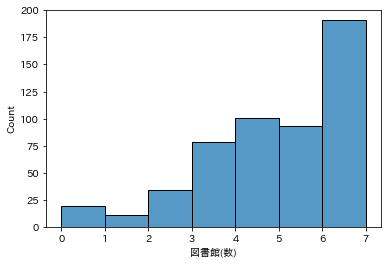

In [43]:
sns.histplot(df_tokyo_district_master['図書館(数)'], bins=7)

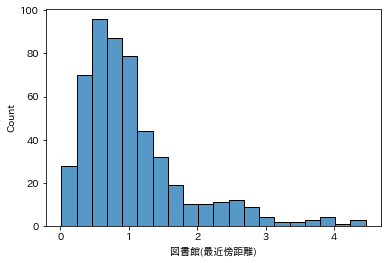

In [46]:
sns.histplot(df_tokyo_district_master['図書館(最近傍距離)'], bins=20)

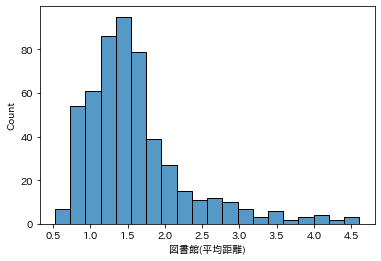

In [47]:
sns.histplot(df_tokyo_district_master['図書館(平均距離)'], bins=20)